<a href="https://colab.research.google.com/github/Sinnick4r/LaboDatos2025/blob/main/TP_Labo_de_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#---------librerias para graficos----------
import matplotlib.pyplot as plt
from scipy.stats import t, norm, gaussian_kde
import seaborn as sns
import geopandas as gpd
import folium
from folium import Choropleth
#------------------------------------------

#se lee el excel y se lmpian espacios
tp = pd.read_excel('BBDD_evaluacion.xlsx', sheet_name='Sheet1')
tp.columns = tp.columns.str.strip()

# revision inicial
duplicados = tp.duplicated().sum()
dimensiones = tp.shape
tipos = tp.dtypes
nnas = tp.isna().sum()

# tabla con tipo de datos y cantidad de NAs por columna
info_df = pd.DataFrame({
  'Tipo de dato': tipos,
  'NAs': nnas,
})
print(info_df)
print('Dimensiones de la tabla:', dimensiones)
print('Elementos Duplicados:', duplicados)

                       Tipo de dato  NAs
PROVINCIA                    object    0
gdp                         float64    0
illiteracy                  float64    2
poverty                     float64    2
deficient_infra             float64    2
school_dropout              float64    0
no_healthcare               float64    2
birth_mortal                float64    2
pop                         float64    1
movie_theatres_per_cap      float64    0
doctors_per_cap             float64    0
Score                       float64    0
poverty_index                object    0
Dimensiones de la tabla: (22, 13)
Elementos Duplicados: 0


In [ ]:
# estadísticas descriptivas

#creacion del dataframe y calculos posteriores
var = 'birth_mortal'

data = tp[var]

# calculo de estadisticas para poner en un dataframe para usar con posterioridad si fuera necesario
media= data.mean()
desv= data.std(ddof=1)
varianza= data.var(ddof=1)
rango= data.max() - data.min()
q1=data.quantile(0.25)
q3=data.quantile(0.75)
iqr=q3-q1
cv= desv / media if media != 0 else np.nan
mediana= data.median()
moda_list= data.mode().tolist()
moda= moda_list[0] if moda_list else np.nan
skewness= data.skew()
kurtosis= data.kurtosis()
p10= data.quantile(0.10)
p90= data.quantile(0.90)
mad_media= (data - data.mean()).abs().mean()
mad_mediana= (data - data.median()).abs().median()

# tabla de resultados
tabla_stats = pd.DataFrame({
    'Estadística': [
        'Media', 'Mediana', 'Q1', 'Q3', 'Desviacion estandar', 'Varianza', 'Rango', 'IQR', 'CV',
        'Moda', 'Asimetria', 'Curtosis', 'P10', 'P90',
        'MAD (media)', 'MAD (mediana)'
    ],
    'Valor': [
        media, mediana, q1, q3, desv, varianza, rango, iqr, cv,
        moda, skewness, kurtosis, p10, p90,
        mad_media, mad_mediana
    ]
})

#print(tabla_stats.to_string(index=False))
#Para el trabajo solo es necesario el describe, el resto es accesorio

tp["birth_mortal"].describe()


,birth_mortal
count,20.000000
mean,4.435000
std,2.566438
min,0.800000
25%,3.000000
50%,3.750000
75%,5.825000
max,11.400000


In [ ]:
# conteo de NAs antes de la imputación
before_na = tp[var].isna().sum()
na_rows  = tp[tp[var].isna()]
print("Filas con NA antes de imputar:")
print(na_rows[['PROVINCIA', var]].to_string(index=False))

# mediana
valor_mediana = tabla_stats.loc[
    tabla_stats['Estadística'] == 'Mediana',
    'Valor'
].iloc[0]

# imputar NAs con l mediana
tp.fillna({var: valor_mediana}, inplace=True)

# conteo de NAs después de la imputación
after_na = tp[var].isna().sum()
print(f"\nMediana usada para imputar: {valor_mediana}")

# resultado final
na_summary = pd.DataFrame({
    'Etapa': ['Antes de sustituir', 'Después de sustituir'],
    'NAs':   [before_na, after_na]
})
print("\nResumen de NAs:")
print(na_summary.to_string(index=False))


Filas con NA antes de imputar:
PROVINCIA  birth_mortal
  Córdoba           NaN
  Formosa           NaN

Mediana usada para imputar: 3.75

Resumen de NAs:
               Etapa  NAs
  Antes de sustituir    2
Después de sustituir    0


In [ ]:
# definición bins y etiquetas según cuartiles
bins = [0, q1, mediana, np.inf]
labels = ['A', 'B', 'C']
# categorías
tp['nivel_bm'] = pd.cut(tp[var], bins=bins, labels=labels, right=False)


descripciones = {'A': 'Bajo', 'B': 'Medio', 'C': 'Alto'}

counts = tp['nivel_bm'].value_counts().reindex(labels, fill_value=0)

df_counts = pd.DataFrame({
    'Categoría': labels,
    'Descripción': [descripciones[c] for c in labels],
    'Frecuencia': counts.values
})

print(df_counts.to_string(index=False))

Categoría Descripción  Frecuencia
        A        Bajo           4
        B       Medio           6
        C        Alto          12


In [ ]:

#normalizacion

minmax_scaler = MinMaxScaler()
tp['N_birth_mortal'] = minmax_scaler.fit_transform(tp[[var]])
comparison = tp[['PROVINCIA', 'birth_mortal', 'N_birth_mortal', 'nivel_bm']]
print(comparison.to_string(index=False))

          PROVINCIA  birth_mortal  N_birth_mortal nivel_bm
       Buenos Aires          4.40        0.339623        C
          Catamarca          1.50        0.066038        A
            Córdoba          3.75        0.278302        C
         Corrientes          5.90        0.481132        C
              Chaco          7.50        0.632075        C
             Chubut          3.00        0.207547        B
         Entre Ríos          3.10        0.216981        B
            Formosa          3.75        0.278302        C
              Jujuy          3.70        0.273585        B
           La Pampa          7.20        0.603774        C
           La Rioja         11.40        1.000000        C
            Mendoza          4.40        0.339623        C
           Misiones          8.10        0.688679        C
            Neuquén          3.30        0.235849        B
          Río Negro          0.80        0.000000        A
              Salta          5.80        0.471698       

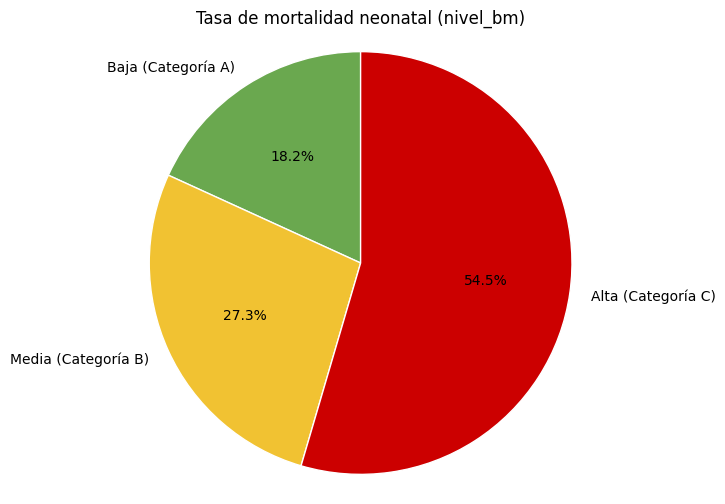

In [ ]:
# grafico de torta
dist_cat = tp['nivel_bm'].value_counts().sort_index()

# Etiquetas descriptivas
label_map = {
    'A': 'Baja (Categoría A)',
    'B': 'Media (Categoría B)',
    'C': 'Alta (Categoría C)'
}

labels = [label_map[c] for c in dist_cat.index]
sizes  = dist_cat.values

color_map = {'A': '#6AA84F', 'B': '#F1C232', 'C': '#CC0000'}
colors    = [color_map[c] for c in dist_cat.index]


fig, ax = plt.subplots(figsize=(6,6))
ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)

ax.set_title('Tasa de mortalidad neonatal (nivel_bm)')
ax.axis('equal')
plt.show()

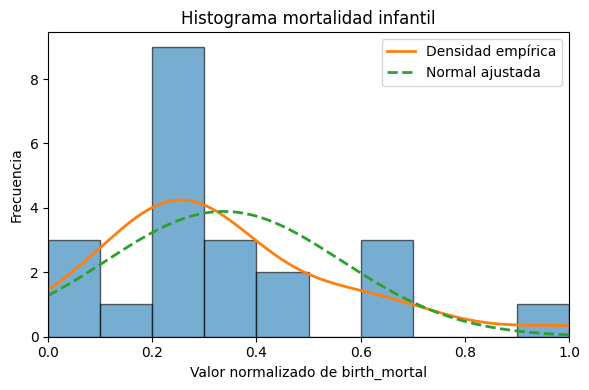

In [ ]:
# histograma

x_mm = tp['N_birth_mortal']
n    = len(x_mm)

fig, ax = plt.subplots(figsize=(6, 4))
counts, bins, _ = ax.hist(
    x_mm,
    bins=10,
    density=False,
    alpha=0.6,
    edgecolor='black'
)

# parametros
bin_width = bins[1] - bins[0]
xx        = np.linspace(0, 1, 200)

# densidad
kde = gaussian_kde(x_mm)
ax.plot(xx, kde(xx) * n * bin_width, linewidth=2, label='Densidad empírica')

# normal ajustada
mu_mm, sigma_mm = norm.fit(x_mm)
pdf_mm = norm.pdf(xx, loc=mu_mm, scale=sigma_mm)
ax.plot(
    xx,
    pdf_mm * n * bin_width,
    linewidth=2,
    linestyle='--',
    label=f'Normal ajustada'
)

# etiquetas
ax.set_xlim(0, 1)
ax.set_xlabel('Valor normalizado de birth_mortal')
ax.set_ylabel('Frecuencia')
ax.set_title('Histograma mortalidad infantil')
ax.legend()

plt.tight_layout()
plt.show()

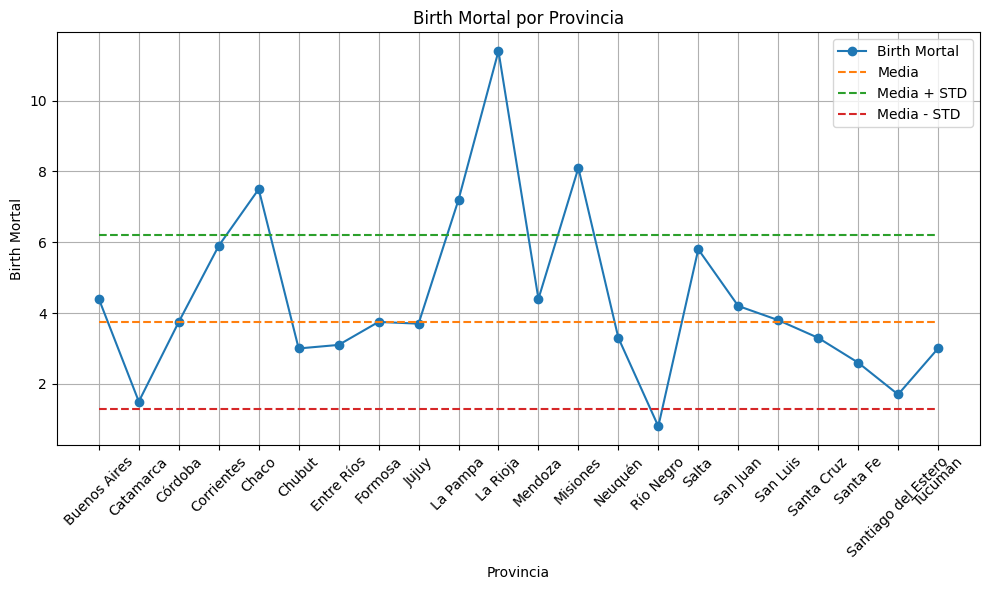

In [ ]:
# Grafico de lineas con desviacion estandar
std_bm_tp  = tp['birth_mortal'].std(ddof=1)

# 2) Crear DataFrame para graficar
df = tp[['PROVINCIA', 'birth_mortal', 'nivel_bm']].copy()
df['mean']    = valor_mediana
df['std_mas'] = valor_mediana + std_bm_tp
df['std_menos'] = valor_mediana - std_bm_tp

# 3) Graficar
plt.figure(figsize=(10, 6))
plt.plot(df['PROVINCIA'], df[var],        label='Birth Mortal',   marker='o')
plt.plot(df['PROVINCIA'], df['mean'],     label='Media',          linestyle='--')
plt.plot(df['PROVINCIA'], df['std_mas'],  label='Media + STD',    linestyle='--')
plt.plot(df['PROVINCIA'], df['std_menos'],label='Media - STD',    linestyle='--')

plt.title('Birth Mortal por Provincia')
plt.xlabel('Provincia')
plt.ylabel('Birth Mortal')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

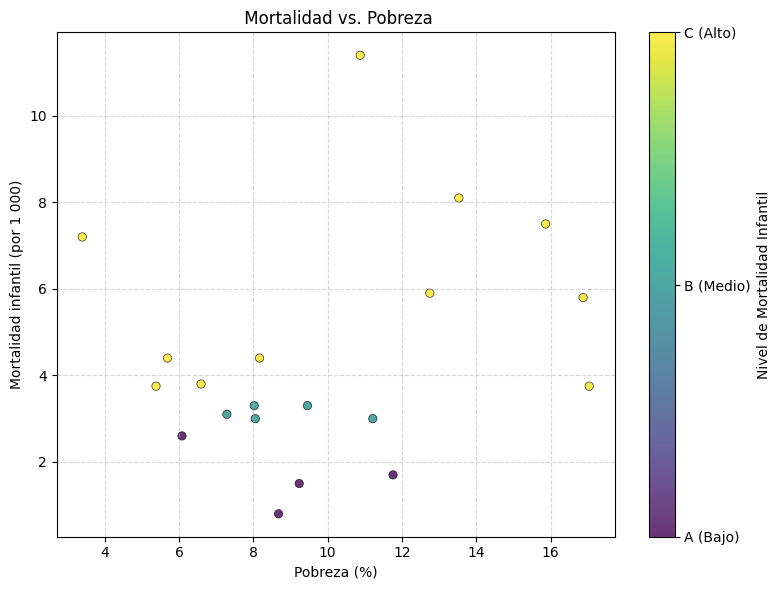

In [ ]:
'''
---------------------------------------------
a partir de aca son graficos que no se usaron
---------------------------------------------
'''
# scatterplot
x = tp['poverty']
y = tp['birth_mortal']

plt.figure(figsize=(8,6))
plt.scatter(x, y,
            c=tp['nivel_bm'].cat.codes,    # colorea por categoría A→0, B→1, C→2
            cmap='viridis',                # paleta de color
            edgecolor='k', linewidth=0.5,  # borde negro fino
            alpha=0.8)                     # transparencia

# etiquetas
plt.xlabel('Pobreza (%)')
plt.ylabel('Mortalidad infantil (por 1 000)')
plt.title(' Mortalidad vs. Pobreza')
cbar = plt.colorbar(ticks=[0,1,2])
cbar.set_label('Nivel de Mortalidad Infantil')
cbar.set_ticklabels(['A (Bajo)', 'B (Medio)', 'C (Alto)'])

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

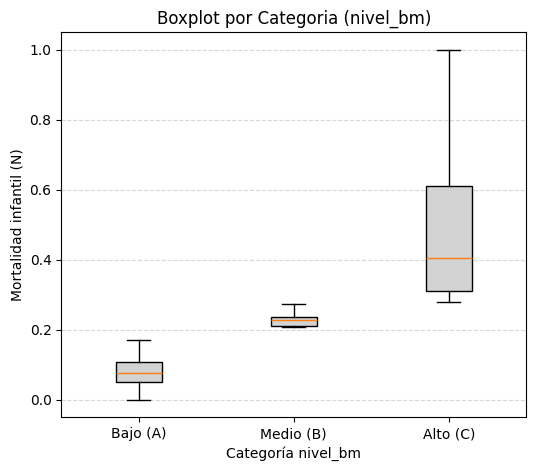

In [ ]:
# Boxplot
groups = ['A','B','C']
data_groups = [tp.loc[tp['nivel_bm']==g, 'N_birth_mortal'] for g in groups]

plt.figure(figsize=(6,5))
plt.boxplot(
    data_groups,
    tick_labels=['Bajo (A)', 'Medio (B)', 'Alto (C)'],  # <— aquí
    patch_artist=True,
    boxprops=dict(facecolor='lightgray', edgecolor='black')
)
plt.title('Boxplot por Categoria (nivel_bm)')
plt.xlabel('Categoría nivel_bm')
plt.ylabel('Mortalidad infantil (N)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

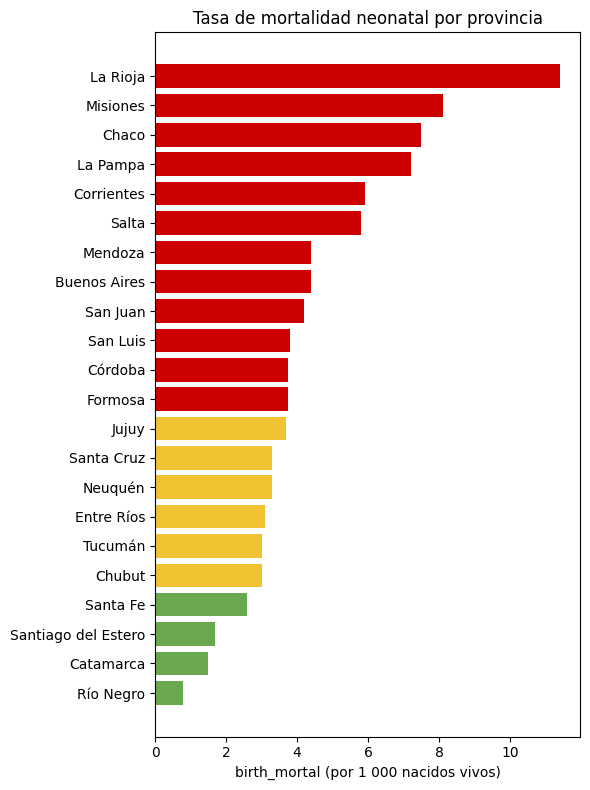

In [ ]:
# se ordena
df_bar = tp.sort_values('birth_mortal', ascending=True)

# se usan los colores que puse en el grafico de torta
color_map = {'A':'#6AA84F', 'B':'#F1C232', 'C':'#CC0000'}
colors = df_bar['nivel_bm'].map(color_map)

# grafico con valores originales porque los normalizados dejaban afuera a Rio Negro
plt.figure(figsize=(6,8))
plt.barh(df_bar['PROVINCIA'], df_bar['birth_mortal'], color=colors)
plt.title('Tasa de mortalidad neonatal por provincia')
plt.xlabel('birth_mortal (por 1 000 nacidos vivos)')
plt.tight_layout()
plt.show()


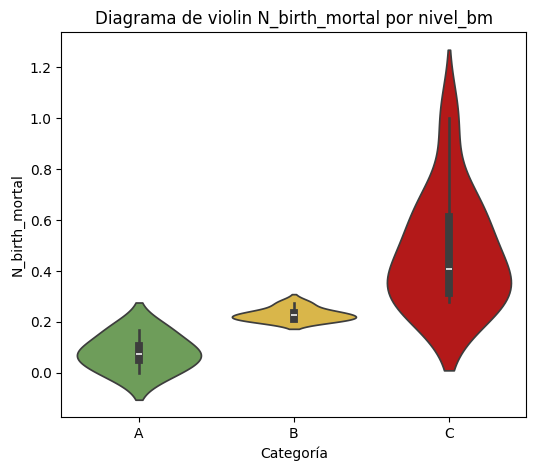

In [ ]:
# diagrama de violines
plt.figure(figsize=(6,5))
sns.violinplot(
    x='nivel_bm',
    y='N_birth_mortal',
    hue='nivel_bm',
    data=tp,
    inner='box',
    palette={'A':'#6AA84F',
             'B':'#F1C232',
             'C':'#CC0000'},
    legend=False
)
plt.title('Diagrama de violin N_birth_mortal por nivel_bm')
plt.xlabel('Categoría')
plt.ylabel('N_birth_mortal')
plt.show()


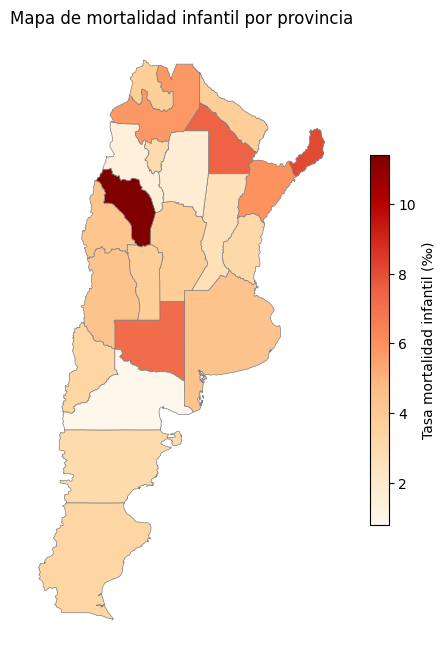

In [ ]:
# el mapa seria un buen grafico pero al faltar dos provincias no sirve

# GeoJSON de provincias de mi github personal
geojson_url = (
    "https://gist.githubusercontent.com/Sinnick4r/"
    "ba9db559f8e50f4b14157ef33ca9ba2d/raw/argentina.geojson"
)
provincias = gpd.read_file(geojson_url)
provincias['prov_clean'] = provincias['NAME_1'].str.upper().str.strip()
tp['prov_clean']         = tp['PROVINCIA'].str.upper().str.strip()
merged = provincias.merge(tp, on='prov_clean', how='left')

# mapa con GeoPandas
fig, ax = plt.subplots(figsize=(8, 8))
merged.plot(
    column='birth_mortal',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    legend_kwds={'label': "Tasa mortalidad infantil (‰)", 'shrink': 0.6},
    ax=ax
)
ax.set_title('Mapa de mortalidad infantil por provincia')
ax.axis('off')
plt.show()

In [ ]:
correlaciones = tp.corr(numeric_only=True)

plt.figure(figsize=(15, 8))
sns.heatmap(correlaciones, annot=True)